# Neural Posterior Estimation

In this notebook we train a Mixture Density Network (MDN) for Neural Posterior Estimation (NPE).

In this example we will:
1. Generate some simulated data.
2. Train a MDN.
3. Make predictions for the model parameters posterior.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import tensorflow.math as tfm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## 1. Generating some data

Like many all of the other notebooks in this repo we start by simulating our data. For the full version of this see `MCMC_zeus.ipynb`.

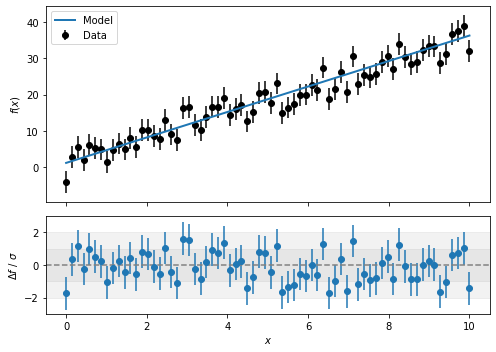

In [2]:
np.random.seed(100) # We set the random seed for numpy so we get the
                    # same synthetic data each time the notebook is run.

def straight_line(x, m, c):
    ''' A straight line model: y = m*x + c '''
    return m*x + c

m_true = 3.5 
c_true = 1.2 

num_points = 70
x = np.linspace(0, 10, num_points)

sigma = 3.0

data = np.random.normal(loc=straight_line(x, m_true, c_true), scale=sigma)

fig, ax = plt.subplots(2,1,sharex=True, figsize=(7,5), gridspec_kw={'height_ratios': [2, 1]})

ax[0].errorbar(x, data, yerr=sigma, fmt="o", color='k', zorder=1, label='Data')
ax[0].plot(x, straight_line(x, m_true, c_true), '-', lw=2, label='Model')
ax[0].legend()
ax[0].set_ylabel(r'$f(x)$')

ax[1].errorbar(x, (data-straight_line(x, m_true, c_true))/sigma, yerr=1., fmt="o")
ax[1].axhline(0., linestyle='--', color='grey')
ax[1].axhspan(-1,1, alpha=0.1, color='grey')
ax[1].axhspan(-2,2, alpha=0.1, color='grey')
ax[1].set_ylim(-3,3)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$\Delta f \ / \ \sigma$')

plt.tight_layout()
plt.show()

## 2. Train a MDN.

We start by defining the functions required to generate the necessary training data.

First we define a function that allows us to randomly sample from the prior. As with all other notebooks in this repo our prior takes the form of a uniform prior on the intercept $c \sim \mathcal{U}(-10,10)$ and a normal prior on the gradient $m \sim \mathcal{N}(3, 10)$.

In [3]:
def prior(N):
    
    rand_c = np.random.uniform(-10., 10., size=(N, ))
    rand_m = np.random.normal(loc=3., scale=10., size=(N, ))
    
    return np.vstack([rand_m, rand_c]).T

Next we define a 'simulator' function. This function generates simulated observations by making model predictions and introduces noise at the same level that we have in our data.

In [4]:
def simulator(theta, sigma, x):
    
    models = theta[:,0]*x.reshape(-1,1) + theta[:,1]

    return np.random.normal(loc=models, scale=sigma).T

We can now use these functions to generate some training data. We generate 50,000 examples, this is similar to the total number of likelihood evaluations when running our MCMC, see `MCMC_zeus.ipynb`. We use 40,000 for training and 10,000 for validation.

In [5]:
trainX = prior(40000)
trainY = simulator(trainX, sigma, x)

valX = prior(10000)
valY = simulator(valX, sigma, x)

trainX.shape, trainY.shape

((40000, 2), (40000, 70))

Before we train our MDN we standardize our training and validations data.

In [6]:
yscaler = StandardScaler()
xscaler = StandardScaler()

trainy = yscaler.fit_transform(trainY)
valy = yscaler.transform(valY)

trainx = xscaler.fit_transform(trainX)
valx = xscaler.transform(valX)

Now we define our MDN. A MDN predicts parameters of a series of component distributions, e.g. a series of Gaussians. The distribution predicted by the network can be written as

$$P(x|y, w) = \sum_i^{n_c} r_i(y, w)\mathcal{N}\left[\mu_i(y,w), C_i(y,w)\right],$$

where $w$ are the weights of the MDN, and $n_c$ is the number of component Gaussians.

For this simple example we only need to use a single component. It is very simple to define this network using [tensorflow-probability](https://www.tensorflow.org/probability/overview).

In [7]:
input_layer1 = Input(shape=(int(trainy.shape[1]),))

d1 = Dense(25, activation = 'tanh')(input_layer1)
d2 = Dense(25, activation = 'tanh')(d1)
d3 = Dense(25, activation = 'tanh')(d2)
d4 = Dense(25, activation = 'tanh')(d3)
d5 = Dense(25, activation = 'tanh')(d4)
output = Dense(5, activation = 'linear')(d5)

dist1 = tfp.layers.MultivariateNormalTriL(2, name="dist1")(output)

MDN = Model(inputs=input_layer1, outputs=dist1)

Our loss function is the negative log-probability $-\ln{P(x|y, w)}$.

In [8]:
neglogprob = lambda y, p_y: -p_y.log_prob(y)

We can now train our MDN. We define a callback that will terminate training when the loss function plateaus.

In [9]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                           verbose=0, mode='min', baseline=None,
                           restore_best_weights=True)
callbacks_list = [early_stop]

MDN.compile(optimizer=Adam(lr=0.00001), loss=neglogprob)
MDN.fit(trainy,trainx, validation_data=[valy, valx] , epochs=200, batch_size=16, verbose=1,
        callbacks=callbacks_list)

/Users/jamie/opt/anaconda3/envs/tf_prob/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
2500/2500 [==============================] - 3s 1ms/step - loss: 1.7356 - val_loss: 1.0662
Epoch 2/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.6788 - val_loss: 0.2478
Epoch 3/200
2500/2500 [==============================] - 3s 1ms/step - loss: -0.0345 - val_loss: -0.2581
Epoch 4/200
2500/2500 [==============================] - 2s 992us/step - loss: -0.3806 - val_loss: -0.5137
Epoch 5/200
2500/2500 [==============================] - 2s 989us/step - loss: -0.6007 - val_loss: -0.7095
Epoch 6/200
2500/2500 [==============================] - 2s 983us/step - loss: -0.7815 - val_loss: -0.8756
Epoch 7/200
2500/2500 [==============================] - 2s 992us/step - loss: -0.9391 - val_loss: -1.0265
Epoch 8/200
2500/2500 [==============================] - 2s 995us/step - loss: -1.0802 - val_loss: -1.1691
Epoch 9/200
2500/2500 [==============================] - 2s 993us/step - loss: -1.2079 - val_loss: -1.2754
Epoch 10/200
2500/2500 [=======================

2500/2500 [==============================] - 3s 1ms/step - loss: -3.2741 - val_loss: -3.2698
Epoch 79/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.2834 - val_loss: -3.2809
Epoch 80/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.2931 - val_loss: -3.2888
Epoch 81/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.3050 - val_loss: -3.3032
Epoch 82/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.3137 - val_loss: -3.3120
Epoch 83/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.3223 - val_loss: -3.3165
Epoch 84/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.3322 - val_loss: -3.3292
Epoch 85/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.3427 - val_loss: -3.3353
Epoch 86/200
2500/2500 [==============================] - 3s 1ms/step - loss: -3.3527 - val_loss: -3.3414
Epoch 87/200
2500/2500 [==============================] - 3

## 3. Making predictions.

Making predictions is very simple. We however need to make sure we standardize our data in the same way as our training data.

In [10]:
posterior = MDN(yscaler.transform(data.reshape(1,-1)))

We can now generate samples from the prdicted distribution and reverse the standardization so that our samples have physical meaning. We save the samples so that they can be compared to the other methods.

In [11]:
samples = xscaler.inverse_transform(np.array(posterior.sample(5000)[:,0,:]))
np.save("NPE_samples", samples)